# **JOBSHEET WEEK 10 - RECURRENT NEURAL NETWORK (RNN)**

- Naresh Pratista
- 2141720057
- TI - 3H

# **Praktikum 1 - RNN untuk Analisis Sentimen**

In [2]:
# Setup
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
# Awalnya ini mengembalikan dataset (teks, pasangan label):

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
# Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Very good martial arts film and Jet Li is the best since the master himself Bruce Lee .Li is excellent as the low key librarian/cop who saves all time and time again . He has a presence and a look that is riveting and believable as the kung fu king that you don't mess with .Francoise Yip is simply beautiful in that mixed race original way that is unique because of her mixed heritage , she has an innocence and an allure all at the same time that I found unforgettable .The villain , the man with the sunglasses and long hair was very good as well but I can't find his name in the credits , can some one help me out with that ? Thanks ! Enjoy Hak hap or Black Mask , in any language its good entertainment !"
 b"I just saw this film in Santa Barbara. My friend knew someone who worked on it, so i thought i'd check it out. i thought it was a really beautiful film and cant wait to go look at it again. the actors were really good and i loved all the music! there was not a lot of talking

### **Buat Teks Encoder**

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 53,  50,   1, ...,   0,   0,   0],
       [ 10,  41, 208, ...,   0,   0,   0],
       [ 11,  18,   7, ...,   0,   0,   0]])

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Very good martial arts film and Jet Li is the best since the master himself Bruce Lee .Li is excellent as the low key librarian/cop who saves all time and time again . He has a presence and a look that is riveting and believable as the kung fu king that you don't mess with .Francoise Yip is simply beautiful in that mixed race original way that is unique because of her mixed heritage , she has an innocence and an allure all at the same time that I found unforgettable .The villain , the man with the sunglasses and long hair was very good as well but I can't find his name in the credits , can some one help me out with that ? Thanks ! Enjoy Hak hap or Black Mask , in any language its good entertainment !"
Round-trip:  very good [UNK] [UNK] film and [UNK] [UNK] is the best since the [UNK] himself [UNK] lee [UNK] is excellent as the low [UNK] [UNK] who [UNK] all time and time again he has a [UNK] and a look that is [UNK] and believable as the [UNK] [UNK] king that you dont mess 

### **Buat Model**

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 9s 9s/step
[0.00392571]


In [14]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 62ms/step
[0.00392571]


In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train Model**

In [16]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 102ms/step - loss: 0.6529 - accuracy: 0.5613 - val_loss: 0.6203 - val_accuracy: 0.7063
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 0.4777 - accuracy: 0.7711 - val_loss: 0.4207 - val_accuracy: 0.8031
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3798 - accuracy: 0.8322 - val_loss: 0.3805 - val_accuracy: 0.8411
Epoch 4/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3427 - accuracy: 0.8508 - val_loss: 0.3647 - val_accuracy: 0.8318
Epoch 5/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3262 - accuracy: 0.8611 - val_loss: 0.3363 - val_accuracy: 0.8609
Epoch 6/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3164 - accuracy: 0.8643 - val_loss: 0.3300 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3094 - accuracy: 0.8694 - val_loss: 0.3353 - val_accuracy

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3158 - accuracy: 0.8606
Test Loss: 0.3158307373523712
Test Accuracy: 0.8605999946594238


(0.0, 0.6705915659666062)

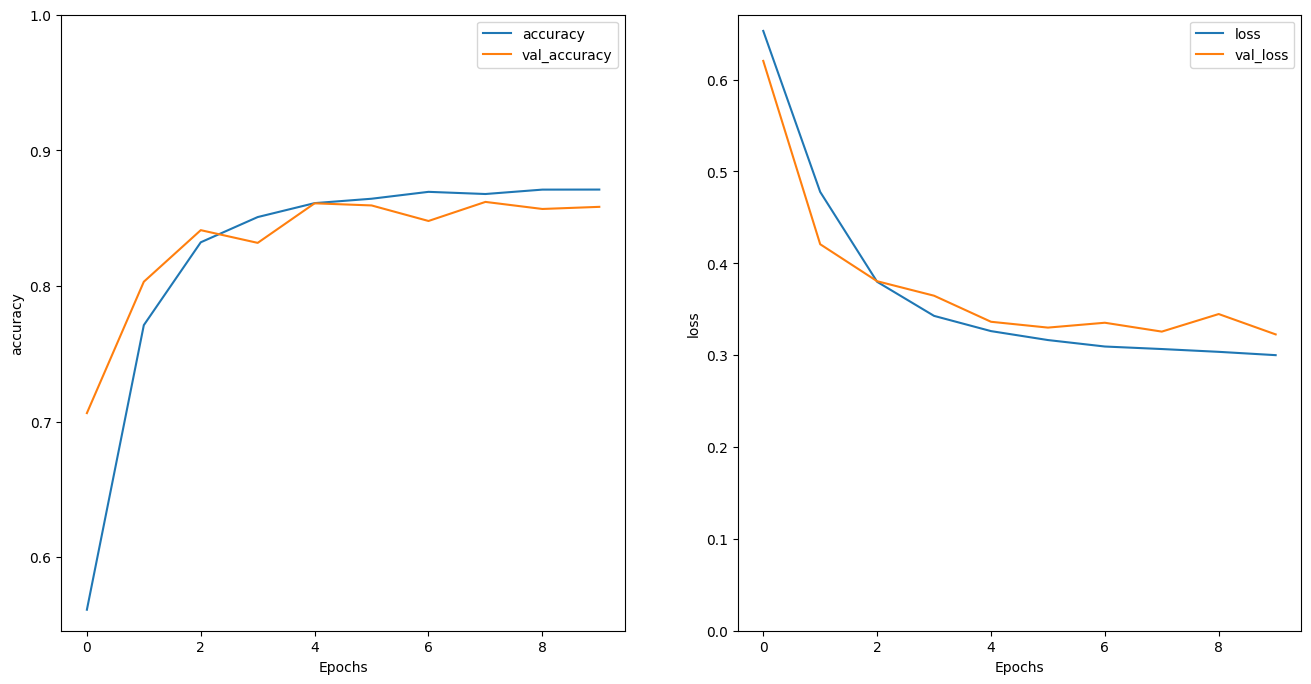

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [19]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


### **Stack two or more LSTM layers**

In [20]:
model = tf.keras.Sequential([encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 [==============================] - 85s 160ms/step - loss: 0.6241 - accuracy: 0.5944 - val_loss: 0.4356 - val_accuracy: 0.7901
Epoch 2/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3870 - accuracy: 0.8312 - val_loss: 0.3466 - val_accuracy: 0.8469
Epoch 3/10
391/391 [==============================] - 60s 154ms/step - loss: 0.3356 - accuracy: 0.8579 - val_loss: 0.3295 - val_accuracy: 0.8505
Epoch 4/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3201 - accuracy: 0.8656 - val_loss: 0.3255 - val_accuracy: 0.8604
Epoch 5/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3132 - accuracy: 0.8673 - val_loss: 0.3203 - val_accuracy: 0.8615
Epoch 6/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3085 - accuracy: 0.8700 - val_loss: 0.3212 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3057 - accuracy: 0.8699 - val_loss: 0.3244 - val_ac

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3361 - accuracy: 0.8596
Test Loss: 0.3360876142978668
Test Accuracy: 0.8596000075340271


In [24]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8865569]]


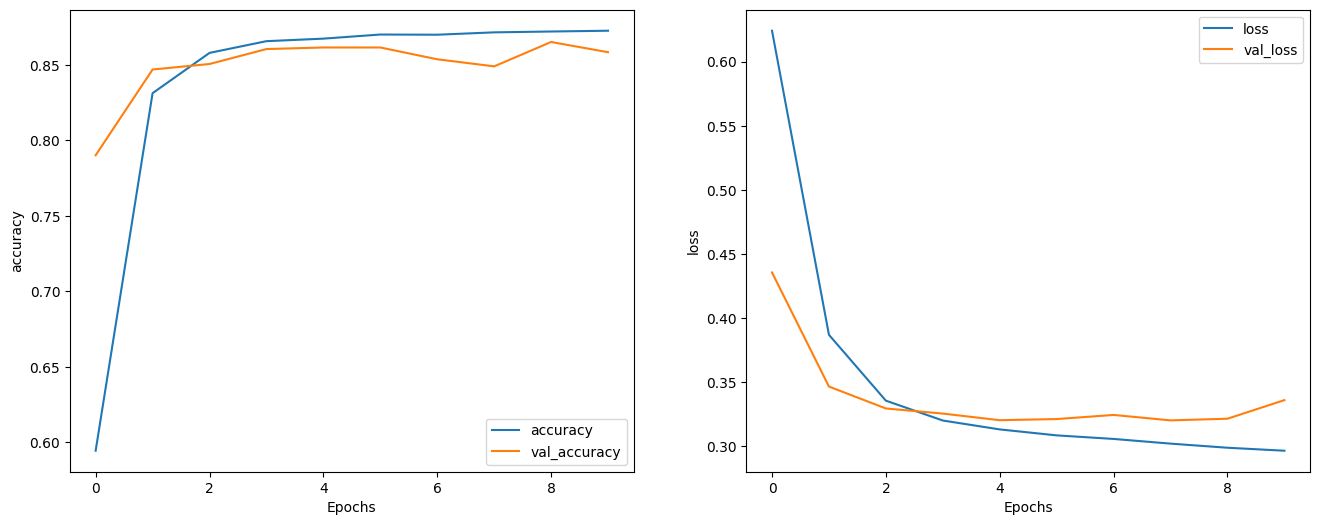

In [25]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## **Praktikum 2 - Generator Teks dengan RNN**

In [26]:
# Import Tensorflow

import tensorflow as tf
import numpy as np
import os
import time

In [28]:
# Download Dataset Shakespeare

path_to_file=tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 1s 1us/step


In [29]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [30]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [31]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## **Olah Teks**

**Vectorize text**

In [32]:
example_texts=['abcdefg','xyz']
chars=tf.strings.unicode_split(example_texts,input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [33]:
ids_from_chars=tf.keras.layers.StringLookup(
vocabulary=list(vocab),mask_token=None)

In [34]:
ids_from_chars=tf.keras.layers.StringLookup(
vocabulary=list(vocab),mask_token=None)

In [35]:
ids=ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [37]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [38]:
chars=chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [39]:
tf.strings.reduce_join(chars,axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [40]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

## **Prediksi**

## **Membuat Training Set dan Target**

In [41]:
all_ids=ids_from_chars(tf.strings.unicode_split(text,'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [42]:
ids_dataset=tf.data.Dataset.from_tensor_slices(all_ids)

In [44]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [45]:
seq_length = 100

In [46]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [47]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [48]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [49]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [50]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [51]:
dataset = sequences.map(split_input_target)

In [52]:
for input_example,target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


## **Membuat Batch Training**

In [53]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## **Buat Model**

In [54]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [55]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [56]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## **Uji Model**

In [57]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [58]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [60]:
sampled_indices

array([ 1, 47, 10, 34, 30, 39, 17, 31, 54, 28, 53, 29, 24, 25, 39, 12, 38,
        3, 45, 41, 25, 38,  0, 40,  6,  8, 16,  7, 63, 35, 33, 39, 12, 52,
        4, 43,  9, 41, 59, 11, 24, 29, 26,  7, 40, 38, 60, 51, 41, 62, 22,
        4, 56, 63, 51, 33,  4, 26, 54, 62, 18, 28, 46, 62, 54, 14, 63, 49,
       47, 16,  0, 30, 33,  9, 39, 22, 53, 10, 21, 31, 41,  4, 38, 22, 61,
       40, 14, 57, 33, 31, 28, 58, 27, 64, 16, 57, 31, 20,  5, 22])

In [61]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'uckingham,\nIs either slain or wounded dangerously;\nI cleft his beaver with a downright blow:\nThat th'

Next Char Predictions:
 b"\nh3UQZDRoOnPKLZ;Y!fbLY[UNK]a'-C,xVTZ;m$d.bt:KPM,aYulbwI$qxlT$MowEOgwoAxjhC[UNK]QT.ZIn3HRb$YIvaArTROsNyCrRG&I"


## **Training Model**

**Tambahan optimizer dan fungsi loss**

In [62]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [63]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1886144, shape=(), dtype=float32)


In [64]:
tf.exp(example_batch_mean_loss).numpy()

65.93137

In [65]:
model.compile(optimizer='adam', loss=loss)

**Konfigurasi Checkpoints**

In [66]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**Lakukan proses Training**

In [67]:
EPOCHS = 20

In [68]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 65ms/step - loss: 2.7056
Epoch 2/20
172/172 [==============================] - 12s 61ms/step - loss: 1.9866
Epoch 3/20
172/172 [==============================] - 12s 61ms/step - loss: 1.7044
Epoch 4/20
172/172 [==============================] - 12s 61ms/step - loss: 1.5442
Epoch 5/20
172/172 [==============================] - 12s 61ms/step - loss: 1.4456
Epoch 6/20
172/172 [==============================] - 13s 61ms/step - loss: 1.3801
Epoch 7/20
172/172 [==============================] - 12s 61ms/step - loss: 1.3277
Epoch 8/20
172/172 [==============================] - 13s 61ms/step - loss: 1.2824
Epoch 9/20
172/172 [==============================] - 13s 61ms/step - loss: 1.2413
Epoch 10/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2016
Epoch 11/20
172/172 [==============================] - 12s 61ms/step - loss: 1.1622
Epoch 12/20
172/172 [==============================] - 12s 61ms/step - loss: 1.1207
E

## **Generate Teks**

In [69]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [70]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [71]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
O, ne'er that Past believe her, give me leave,
By infame to make who stoop sprives him to his
half, the tires of one some honest bear,
Thou madst scound that was, his faults,
From whom they do imself a servant of
The throne it to his sight.

First Servant:
Will't please your cause?

COMINIUS:
I have seen here and I'll lay
As strucken him. But leave your honour's good,
For I have been our queen and my unblowed.

KING RICHARD II:
Thanks, dear son well that will return best.
There is an irtage made thy spains or two!
And who shining subjects? precious welcome, sir!

ESCALUS:
Either my eyel?

Third Citizen:
Be not so lies it, thou so often haste
Thou wilt put in his tent?

ALONSO:
I will find your great some queen so well as I.
Nurse!

Nurse:
I have:
It beloved my heart to melanous her:
Under thy beauty's wife, and dull thy brother,
Nor is my wind, my brother Angelo; look thee,
Ragged nor the people; my own soul'd valour,
Even to time repost to him and remoting
Than appeal of it. AN

## **Ekspor Model Generator**

In [72]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [73]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Sweet sir, that way; for I do sent before the staves.

GLOUCESTER:
Marry, as the character, he cont


# **Tugas**

**1. Jalankan Model dan hitung loss dengan tf.GradientTape.**

**2. Hitung update dan terapkan pada model dengan optimizer**

In [74]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
          grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

Kode diatas menerapkan train_step method sesuai dengan  Keras' train_step conventions. Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras Model.compile and Model.fit methods.

In [75]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [76]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [77]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 18s 62ms/step - loss: 2.6933


Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [79]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

# saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1580
Epoch 1 Batch 50 Loss 2.0336
Epoch 1 Batch 100 Loss 1.9648
Epoch 1 Batch 150 Loss 1.8515

Epoch 1 Loss: 1.9746
Time taken for 1 epoch 14.83 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.7830
Epoch 2 Batch 50 Loss 1.7477
Epoch 2 Batch 100 Loss 1.6566
Epoch 2 Batch 150 Loss 1.6494

Epoch 2 Loss: 1.6972
Time taken for 1 epoch 12.37 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6495
Epoch 3 Batch 50 Loss 1.5345
Epoch 3 Batch 100 Loss 1.5558
Epoch 3 Batch 150 Loss 1.5488

Epoch 3 Loss: 1.5397
Time taken for 1 epoch 12.17 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4268
Epoch 4 Batch 50 Loss 1.4396
Epoch 4 Batch 100 Loss 1.4521
Epoch 4 Batch 150 Loss 1.3802

Epoch 4 Loss: 1.4436
Time taken for 1 epoch 12.13 sec
_____________________________________________________________________

sebutkan perbedaanya dengan praktikum 2?

    > Perbedaan antara kode di atas dengan praktikum 2 terletak pada beberapa bagian, yaitu:
        - Pertama, mereka berbeda dalam arsitektur model, dengan praktikum 2 menggunakan RNN sederhana, sementara pelatihan tugas mungkin memanfaatkan arsitektur yang lebih kompleks seperti GRU.
        - Kedua, durasi pelatihan berbeda, dengan praktikum 2 menjalankan model selama 20 epoch dan pelatihan tugas selama 10 epoch.
        - Ketiga, prosedur pelatihan juga berbeda, dengan praktikum 2 menggunakan API model.fit() bawaan Keras yang lebih sederhana, sedangkan pelatihan tugas mengimplementasikan loop pelatihan khusus dengan train_step untuk lebih banyak kontrol.
        - Keempat, output hasil pelatihan juga berbeda, di mana praktikum 2 hanya memberikan informasi singkat tentang loss, sementara pelatihan tugas mencantumkan loss untuk setiap batch dan epoch serta waktu eksekusi untuk setiap epoch.
        - Terakhir, waktu eksekusi per epoch juga dapat bervariasi, dengan praktikum 2 mungkin lebih cepat dalam pengaturan default dan pelatihan tugas mungkin memerlukan lebih banyak waktu karena lebih banyak epoch.